In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.img_tiles as tilers
import utm
import json
from matplotlib.lines import Line2D
from pymavlink import mavutil
import sys
import pyvista as pv

if 'REPO_PATH' not in locals():
    REPO_PATH = os.path.abspath('../')
    os.chdir(REPO_PATH)
    

from dubinstracking.pathplanning import OrbitFactory, MorphingOrbit

mpl.rcParams.update({
    'font.size': 8,
    'legend.fontsize': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'xtick.labelsize':8,
    'ytick.labelsize':8
})

In [4]:
logFiles = [
    'data/experimental/log118.bin',
    'data/experimental/log121.bin',
    'data/experimental/log122.bin',
    'data/experimental/log119.bin',
    'data/experimental/log120.bin',
    'data/experimental/log123.bin',
    'data/experimental/sim_3ms_35m_r50m_fixed_11m.bin',
    'data/experimental/sim_3ms_35m_r50m_fixed_23m.bin',
    'data/experimental/sim_3ms_35m_r50m_fixed_35m.bin',
    'data/experimental/sim_3ms_35m_r50m.bin'
]

localAll = []
globalAll = []
guipAll = []
origins = []
for logFile in logFiles:
    print(logFile)
    mlog: mavutil.mavfile = mavutil.mavlink_connection(logFile)
    messages = {}
    while True:
        message = mlog.recv_match()
        if message is None:
            break
        if message.get_type() not in messages:
            messages[message.get_type()] = []
        msg = message.to_dict()
        messages[message.get_type()].append(msg)
        if msg['mavpackettype'].upper() == 'FILE':
            continue

    for key in messages:
        messages[key] = pd.DataFrame(messages[key])
    

    localAll.append(messages['XKF1'])
    globalAll.append(messages['POS'])
    guipAll.append(messages['GUIP'])
    origins.append(messages['ORGN'])


data/experimental/log118.bin
data/experimental/log121.bin
data/experimental/log122.bin
data/experimental/log119.bin
data/experimental/log120.bin
data/experimental/log123.bin
data/experimental/sim_3ms_35m_r50m_fixed_11m.bin
data/experimental/sim_3ms_35m_r50m_fixed_23m.bin
data/experimental/sim_3ms_35m_r50m_fixed_35m.bin
data/experimental/sim_3ms_35m_r50m.bin


In [5]:
missionDyn = 'data/experimental/circles_3ms_35m_r50m.json'
missionFixed = 'data/experimental/circles_3ms_35m_r50m_fixed_35m.json'
missionSimSmall = 'data/experimental/circles_3ms_35m_r50m_fixed_11m.json'
missionSimBig = 'data/experimental/circles_3ms_35m_r50m_fixed_23m.json'
missionOrigin = 'data/experimental/gps_origin.json'
missionVolumes = 'data/experimental/volumes.json'

with open(missionDyn) as f:
    plan = json.load(f)
orbitsDyn = [OrbitFactory.fromJson(p) for p in plan]

with open(missionFixed) as f:
    plan = json.load(f)
orbitsFixed = [OrbitFactory.fromJson(p) for p in plan]

with open(missionSimSmall) as f:
    plan = json.load(f)
orbitsSmall = [OrbitFactory.fromJson(p) for p in plan]

with open(missionSimBig) as f:
    plan = json.load(f)
orbitsBig = [OrbitFactory.fromJson(p) for p in plan]

orbitList = [
    orbitsDyn,
    orbitsDyn,
    orbitsDyn,
    orbitsFixed,
    orbitsFixed,
    orbitsFixed,
    orbitsSmall,
    orbitsBig,
    orbitsFixed,
    orbitsDyn
]

with open(missionOrigin) as f:
    missionGPSOrigin = json.load(f)
    x, y, _, _ = utm.from_latlon(*missionGPSOrigin)
    missionHome = [x,y]

In [6]:
APPROX_ZERO = 1e-4

def getUnique(queue):
    # check the uniqueness of points for degenerate cases
    r = []
    while len(queue) > 0:
        current = queue.pop(0)
        r.append(current)
        i = 0
        while i < len(queue):
            if np.linalg.norm(np.subtract(current, queue[i])) < APPROX_ZERO:
                queue.pop(i)
            else:
                i += 1
    return r

def raytrace(volume: pv.PolyData, other: np.ndarray, ray: np.ndarray):
    
    points = volume.points[volume.faces.reshape(-1, 4)[:, 1:]]
    v1 = points[:, 1, :] - points[:, 0, :]
    v2 = points[:, 2, :] - points[:, 0, :]
    h = np.cross(ray, v2)
    a = np.einsum('ji, ji -> j', h, v1)
    f = 1.0 / a
    s = other - points[:, 0]
    u = f * np.einsum('ji, ji -> j', s, h)
    valid = (u >= 0) & (u <= 1) 
    q = np.cross(s[valid], v1[valid])
    v = f[valid] * np.einsum('i, ji -> j', ray, q)
    t = f[valid] * np.einsum('ji, ji -> j', q, v2[valid])
    valid = (v >= 0) & (v + u[valid] <= 1) & (t > APPROX_ZERO)
    queue = (other + np.multiply.outer(t[valid], ray)).tolist()
    unique = getUnique(queue)
    return unique

reader = pv.get_reader('data/environments/battcave/battcave.ply')
env = reader.read()

np.float64(0.9903765690376569)

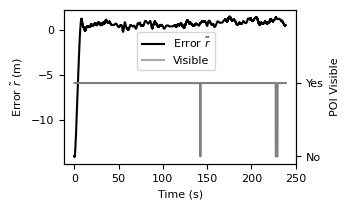

In [7]:
k = 2
guip = guipAll[k]
localPosition = localAll[k]
orbits = orbitList[k]
globalOrigin = origins[k]

localPosition['x'] = localPosition['PN'].apply(float)
localPosition['y'] = localPosition['PE'].apply(float)
localPosition['z'] = localPosition['PD'].apply(float)

origin = (globalOrigin['Lat'].iloc[-1], globalOrigin['Lng'].iloc[-1], globalOrigin['Alt'].iloc[-1])
x, y, num, let = utm.from_latlon(origin[0], origin[1])
home = (x, y, globalOrigin['Alt'].iloc[-1])
zone = (num, let)

missionUAVhomeOffset = np.subtract(home, missionHome + [home[-1]])


pdt = [np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0) for i in range(len(orbits) - 1)]
dt = np.sum(pdt)
n = np.floor(dt * 30)
tstart = guip['TimeUS'].iloc[0] * 1e-6
t = np.linspace(tstart, tstart + dt, int(n))
tend = tstart + dt

ptstep = []
pt = tstart
for i in pdt:
    ptstep.append(pt)
    pt += i
ptstep.append(pt)

poix = [orbit.g_0[0] for orbit in orbits]
poiy = [orbit.g_0[1] for orbit in orbits]
roiz = np.interp(t, [t[0], t[3874], t[-1]], [.5, 1.0, 2.0])


roix = np.interp(t, ptstep, poix)
localx = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['y'] + missionUAVhomeOffset[0])
roiy = np.interp(t, ptstep, poiy)
localy = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['x'] + missionUAVhomeOffset[1])
localz = np.interp(t, localPosition['TimeUS'] * 1e-6, -localPosition['z'])
xDist = localx - roix
yDist = localy - roiy

theta = np.arctan2(yDist, xDist)
i = 0
dt = np.linalg.norm(orbits[0].g_0 - orbits[1].g_0) / np.linalg.norm(orbits[0].g_dot_0)
orbit = MorphingOrbit(orbits[0], orbits[1], 0, dt)
desiredDistance = []
predVisible = np.zeros_like(t)
for j, tvalue in enumerate(t):
    if tvalue > orbit.t2 + tstart:
        i += 1
        if i + 1 >= len(orbits):
            break
        dt = np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0)
        orbit = MorphingOrbit(orbits[i], orbits[i + 1], orbit.t2, orbit.t2 + dt)
    desiredDistance.append(orbit.radius(theta[j], tvalue - tstart))
    
    point = np.array([localx[j], localy[j], localz[j]])
    poi = np.array([roix[j], roiy[j], roiz[j]])
    ray = point - poi
    predVisible[j] = len(raytrace(env, poi, ray)) == 0

totalDistance = np.sqrt(xDist ** 2 + yDist ** 2)
n = min(t.shape[0], totalDistance.shape[0], len(desiredDistance))
fig = plt.figure(figsize=(3.0, 2))
ax = fig.add_subplot()
ax1 = ax.twinx()
ax1.plot(t - tstart, predVisible, color='gray')
ax1.set_ylabel('POI Visible')
ax1.set_yticks([0, 1], ['No', 'Yes'])
ax1.set_ylim([-0.1, 2])

ax.plot(t[:n] - tstart, totalDistance[:n] - desiredDistance[:n], 'k')
ax.set_xlabel(r'Time (s)')
ax.set_ylabel(r'Error $\tilde{r}$ (m)')

fig.legend(
    [Line2D([0], [0], color='k'),
     Line2D([0], [0], color='darkgray')],
    [
        r'Error $\tilde{r}$',
        'Visible'
    ],
    loc='lower center',
    bbox_to_anchor=(.5, .55)
)
    
fig.savefig(f'notebooks/figures/tracking_distance_{k}.pdf', bbox_inches='tight')


np.sum(predVisible) / predVisible.shape[0]


0.9833565783356578 0.6927010692701069
[0.97991632 0.97977685 0.99037657 0.70292887 0.71059972 0.66457462]


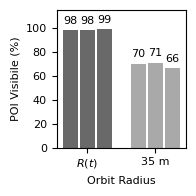

In [13]:
visibility = []
for k in range(len(logFiles[:6])):
    guip = guipAll[k]
    localPosition = localAll[k]
    orbits = orbitList[k]
    globalOrigin = origins[k]

    localPosition['x'] = localPosition['PN'].apply(float)
    localPosition['y'] = localPosition['PE'].apply(float)
    localPosition['z'] = localPosition['PD'].apply(float)

    origin = (globalOrigin['Lat'].iloc[-1], globalOrigin['Lng'].iloc[-1], globalOrigin['Alt'].iloc[-1])
    x, y, num, let = utm.from_latlon(origin[0], origin[1])
    home = (x, y, globalOrigin['Alt'].iloc[-1])
    zone = (num, let)

    missionUAVhomeOffset = np.subtract(home, missionHome + [home[-1]])


    pdt = [np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0) for i in range(len(orbits) - 1)]
    dt = np.sum(pdt)
    n = np.floor(dt * 30)
    tstart = guip['TimeUS'].iloc[0] * 1e-6
    t = np.linspace(tstart, tstart + dt, int(n))
    tend = tstart + dt

    ptstep = []
    pt = tstart
    for i in pdt:
        ptstep.append(pt)
        pt += i
    ptstep.append(pt)

    poix = [orbit.g_0[0] for orbit in orbits]
    poiy = [orbit.g_0[1] for orbit in orbits]
    roiz = np.interp(t, [t[0], t[3874], t[-1]], [.5, 1.0, 2.0])


    roix = np.interp(t, ptstep, poix)
    localx = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['y'] + missionUAVhomeOffset[0])
    roiy = np.interp(t, ptstep, poiy)
    localy = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['x'] + missionUAVhomeOffset[1])
    localz = np.interp(t, localPosition['TimeUS'] * 1e-6, -localPosition['z'])

    predVisible = np.zeros_like(t)
    for j, tvalue in enumerate(t):
        point = np.array([localx[j], localy[j], localz[j]])
        poi = np.array([roix[j], roiy[j], roiz[j]])
        ray = point - poi
        predVisible[j] = len(raytrace(env, poi, ray)) == 0
    
    visibility.append(np.sum(predVisible) / predVisible.shape[0])

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot()

rounded = (np.round(visibility, 2) * 100).astype(np.int32)
visibility = np.array(visibility)
width = 1
margin = .1


dyn = ax.bar(np.arange(3) * width, visibility[:3] * 100, width=width * (1 - margin), color='dimgray')
ax.bar_label(dyn, rounded[:3], padding=3)
fixed = ax.bar(np.arange(3, 6) * width + 1, visibility[3:] * 100, width=width* (1 - margin), color='darkgray')
ax.bar_label(fixed, rounded[3:], padding=3)
ax.set_ylim([0, 115])
ax.set_xticks([1, 5], ['$R(t)$', '35 m'])
ax.set_ylabel('POI Visibile (%)')
ax.set_xlabel('Orbit Radius')
fig.tight_layout()

fig.savefig('notebooks/figures/visibility_results.pdf')

print(visibility[:3].mean(), visibility[3:].mean())
print(visibility)

90.45501253793293 [np.float64(12.305267965577121), np.float64(12.305267965577118), np.float64(12.305267965577116), np.float64(12.305267965577116), np.float64(10.308485168906119), np.float64(10.308485168906117), np.float64(10.30848516890612), np.float64(10.308485168906119)]


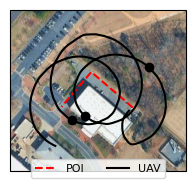

In [9]:
k = 5
pathlen = [np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) for i in range(len(orbits) - 1)]
print(sum(pathlen), pathlen)
pdt = [np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0) for i in range(len(orbits) - 1)]
dt = np.sum(pdt)
tstart = guip['TimeUS'].iloc[0] * 1e-6
tend = tstart + dt

pts = [
    1282 / 30 + tstart,
    2406 / 30 + tstart,
    4886 / 30 + tstart
]

globalPosition = globalAll[k]
guip = guipAll[k]
origin = (globalOrigin['Lat'].iloc[-1], globalOrigin['Lng'].iloc[-1], globalOrigin['Alt'].iloc[-1])
orbits = orbitList[k]
x, y, num, let = utm.from_latlon(origin[0], origin[1])
home = (x, y, globalOrigin['Alt'].iloc[-1])
zone = (num, let)

pdt = [np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0) for i in range(len(orbits) - 1)]
dt = np.sum(pdt)
tstart = guip['TimeUS'].iloc[0] * 1e-6
tend = tstart + dt


missionUAVhomeOffset = np.subtract(home, missionHome + [home[-1]])


fig = plt.figure(figsize=(2,2))
tiler = tilers.GoogleTiles(style='satellite')
cm = plt.get_cmap('cool')
ds = .0002

ax = fig.add_subplot(projection=tiler.crs)
data = globalPosition[(globalPosition['TimeUS'] > tstart * 1e6) & (globalPosition['TimeUS'] < tend * 1e6)]


poix = [orbit.g_0[0] for orbit in orbits]
poiy = [orbit.g_0[1] for orbit in orbits]

lat, lon = utm.to_latlon(poix + x - missionUAVhomeOffset[0], poiy + y - missionUAVhomeOffset[1], zone[0], zone[1])

ax.stock_img()
targetLine, = ax.plot(lon, lat, transform=ccrs.PlateCarree(), color='r', ls='--')
quadLine, = ax.plot(data['Lng'], data['Lat'], color='k', transform=ccrs.PlateCarree())

slon = np.interp(pts, data['TimeUS'] * 1e-6, data['Lng'])
slat = np.interp(pts, data['TimeUS'] * 1e-6, data['Lat'])
ax.scatter(slon, slat, transform=ccrs.PlateCarree(), c='k')
ax.set_extent([data['Lng'].min() - ds , data['Lng'].max() + ds, data['Lat'].min() - ds, data['Lat'].max() + ds], crs=ccrs.PlateCarree())
ax.add_image(tiler, 18)

fig.legend(handles=[targetLine, quadLine], labels=['POI', 'UAV'], loc=8, ncols=2, bbox_to_anchor=(.5, .0325))
fig.tight_layout()

fig.savefig(f'notebooks/figures/tracking_gps_{k}.pdf', bbox_inches='tight')


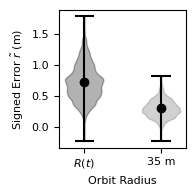

In [10]:
distanceDiffs = []
for k in range(len(logFiles[:6])):
    guip = guipAll[k]
    localPosition = localAll[k]
    orbits = orbitList[k]
    globalOrigin = origins[k]

    localPosition['x'] = localPosition['PN'].apply(float)
    localPosition['y'] = localPosition['PE'].apply(float)
    localPosition['z'] = localPosition['PD'].apply(float)

    origin = (globalOrigin['Lat'].iloc[-1], globalOrigin['Lng'].iloc[-1], globalOrigin['Alt'].iloc[-1])
    x, y, num, let = utm.from_latlon(origin[0], origin[1])
    home = (x, y, globalOrigin['Alt'].iloc[-1])
    zone = (num, let)

    missionUAVhomeOffset = np.subtract(home, missionHome + [home[-1]])


    pdt = [np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0) for i in range(len(orbits) - 1)]
    dt = np.sum(pdt)
    n = np.floor(dt * 30)
    tstart = guip['TimeUS'].iloc[0] * 1e-6
    t = np.linspace(tstart, tstart + dt, int(n))
    tend = tstart + dt

    ptstep = []
    pt = tstart
    for i in pdt:
        ptstep.append(pt)
        pt += i
    ptstep.append(pt)

    poix = [orbit.g_0[0] for orbit in orbits]
    poiy = [orbit.g_0[1] for orbit in orbits]


    roix = np.interp(t, ptstep, poix)
    localx = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['y'] + missionUAVhomeOffset[0])
    roiy = np.interp(t, ptstep, poiy)
    localy = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['x'] + missionUAVhomeOffset[1])
    xDist = localx - roix
    yDist = localy - roiy

    theta = np.arctan2(yDist, xDist)
    i = 0
    dt = np.linalg.norm(orbits[0].g_0 - orbits[1].g_0) / np.linalg.norm(orbits[0].g_dot_0)
    orbit = MorphingOrbit(orbits[0], orbits[1], 0, dt)
    desiredDistance = []
    for j, tvalue in enumerate(t):
        if tvalue > orbit.t2 + tstart:
            i += 1
            if i + 1 >= len(orbits):
                break
            dt = np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0)
            orbit = MorphingOrbit(orbits[i], orbits[i + 1], orbit.t2, orbit.t2 + dt)
        desiredDistance.append(orbit.radius(theta[j], tvalue - tstart))

    totalDistance = np.sqrt(xDist ** 2 + yDist ** 2)
    distanceDiffs.append(totalDistance - desiredDistance)

n = 500

dyn = np.concatenate([d[n:] for d in distanceDiffs[:3]])
fixed = np.concatenate([d[n:] for d in distanceDiffs[3:]])

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot()

violin = ax.violinplot([dyn, fixed])
ax.scatter([1, 2], [dyn.mean(), fixed.mean()], c='k')
ax.set_xticks([1, 2], ['$R(t)$', '35 m'])
ax.set_xlabel('Orbit Radius')
ax.set_ylabel(r'Signed Error $\tilde{r}$ (m)')

violin['cmins'].set_color('k')
violin['cmaxes'].set_color('k')
violin['cbars'].set_color('k')
violin['bodies'][0].set_color('k')
violin['bodies'][1].set_color('dimgray')
fig.tight_layout()
fig.savefig('notebooks/figures/tracking_error.pdf')

In [11]:
k = 2
guip = guipAll[k]
localPosition = localAll[k]
orbits = orbitList[k]
globalOrigin = origins[k]

localPosition['x'] = localPosition['PN'].apply(float)
localPosition['y'] = localPosition['PE'].apply(float)
localPosition['z'] = localPosition['PD'].apply(float)

origin = (globalOrigin['Lat'].iloc[-1], globalOrigin['Lng'].iloc[-1], globalOrigin['Alt'].iloc[-1])
x, y, num, let = utm.from_latlon(origin[0], origin[1])
home = (x, y, globalOrigin['Alt'].iloc[-1])
zone = (num, let)

missionUAVhomeOffset = np.subtract(home, missionHome + [home[-1]])


pdt = [np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0) for i in range(len(orbits) - 1)]
dt = np.sum(pdt)
n = np.floor(dt * 30)
tstart = guip['TimeUS'].iloc[0] * 1e-6
t = np.linspace(tstart, tstart + dt, int(n))
tend = tstart + dt

ptstep = []
pt = tstart
for i in pdt:
    ptstep.append(pt)
    pt += i
ptstep.append(pt)

poix = [orbit.g_0[0] for orbit in orbits]
poiy = [orbit.g_0[1] for orbit in orbits]


roix = np.interp(t, ptstep, poix)
localx = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['y'] + missionUAVhomeOffset[0])
roiy = np.interp(t, ptstep, poiy)
localy = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['x'] + missionUAVhomeOffset[1])
xDist = localx - roix
yDist = localy - roiy

theta = np.arctan2(yDist, xDist)
i = 0
dt = np.linalg.norm(orbits[0].g_0 - orbits[1].g_0) / np.linalg.norm(orbits[0].g_dot_0)
orbit = MorphingOrbit(orbits[0], orbits[1], 0, dt)
desiredDistance = []
for j, tvalue in enumerate(t):
    if tvalue > orbit.t2 + tstart:
        i += 1
        if i + 1 >= len(orbits):
            break
        dt = np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0)
        orbit = MorphingOrbit(orbits[i], orbits[i + 1], orbit.t2, orbit.t2 + dt)
    desiredDistance.append(orbit.radius(theta[j], tvalue - tstart))

totalDistance = np.sqrt(xDist ** 2 + yDist ** 2)
distanceDiffs = totalDistance - desiredDistance

rmse = np.sqrt((distanceDiffs[500:] ** 2).sum() / distanceDiffs.shape[0])
print(f'RMSE {rmse}')

RMSE 0.7432122240453668


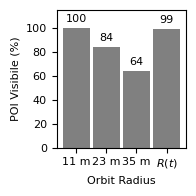

In [12]:
visibility = []
for k in range(6, len(logFiles)):
    guip = guipAll[k]
    localPosition = localAll[k]
    orbits = orbitList[k]
    globalOrigin = origins[k]

    localPosition['x'] = localPosition['PN'].apply(float)
    localPosition['y'] = localPosition['PE'].apply(float)
    localPosition['z'] = localPosition['PD'].apply(float)

    origin = (globalOrigin['Lat'].iloc[-1], globalOrigin['Lng'].iloc[-1], globalOrigin['Alt'].iloc[-1])
    x, y, num, let = utm.from_latlon(origin[0], origin[1])
    home = (x, y, globalOrigin['Alt'].iloc[-1])
    zone = (num, let)

    missionUAVhomeOffset = np.subtract(home, missionHome + [home[-1]])


    pdt = [np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0) / np.linalg.norm(orbits[i].g_dot_0) for i in range(len(orbits) - 1)]
    dt = np.sum(pdt)
    n = np.floor(dt * 30)
    tstart = guip['TimeUS'].iloc[0] * 1e-6
    t = np.linspace(tstart, tstart + dt, int(n))
    tend = tstart + dt

    ptstep = []
    pt = tstart
    for i in pdt:
        ptstep.append(pt)
        pt += i
    ptstep.append(pt)

    poix = [orbit.g_0[0] for orbit in orbits]
    poiy = [orbit.g_0[1] for orbit in orbits]
    roiz = np.interp(t, [t[0], t[3874], t[-1]], [.5, 1.0, 2.0])


    roix = np.interp(t, ptstep, poix)
    localx = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['y'] + missionUAVhomeOffset[0])
    roiy = np.interp(t, ptstep, poiy)
    localy = np.interp(t, localPosition['TimeUS'] * 1e-6, localPosition['x'] + missionUAVhomeOffset[1])
    localz = np.interp(t, localPosition['TimeUS'] * 1e-6, -localPosition['z'])

    predVisible = np.zeros_like(t)
    for j, tvalue in enumerate(t):        
        point = np.array([localx[j], localy[j], localz[j]])
        poi = np.array([roix[j], roiy[j], roiz[j]])
        ray = point - poi
        predVisible[j] = len(raytrace(env, poi, ray)) == 0

    visibility.append(predVisible)

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot()

visibility = np.array(visibility)
visibilityPct = visibility.sum(axis=1) / visibility.shape[1]
rounded = (np.round(visibilityPct, 2) * 100).astype(np.int32)

width = 1
margin = .1

graph = ax.bar(np.arange(4) * width, visibilityPct * 100, width=width * (1 - margin), color='gray')
ax.bar_label(graph, rounded, padding=3)
ax.set_xticks([0, 1, 2, 3,], ['11 m', '23 m', '35 m', '$R(t)$'])
ax.set_ylim([0, 115])
ax.set_ylabel('POI Visibile (%)')
ax.set_xlabel('Orbit Radius')
fig.tight_layout()

fig.savefig('notebooks/figures/simulated_visibility.pdf')